# Reproducibility Lab: Functional Connectivity and Pain

## HYPOTHESIS-DRIVEN ANALYSIS

## Learning Objectives

By the end of this lab, you will be able to:
- Formulate a hypothesis about brain-behavior relationships based on prior literature
- Use analytical tools (covariates, outliers, subgroups) to refine your analysis
- Pre-register an analysis plan before seeing your results
- Conduct a hypothesis-driven functional connectivity analysis with Bonferroni correction
- Validate findings in an independent dataset
- Present rigorous, replicable findings to the class

---

## Part 1: Setup and Load Data

In [3]:
# Install nilearn for brain visualizations and download data files
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'nilearn', '-q'])

import os
import urllib.request

base_url = 'https://raw.githubusercontent.com/cmahlen/python-stats-demo/main/'
files_needed = [
    'lab_helpers.py',
    'atlas_labels.txt',
    'data/roi_mni_coords.npy',
    'data/pain_discovery.npz',
    'data/pain_validation.npz',
]

os.makedirs('data', exist_ok=True)
for f in files_needed:
    if not os.path.exists(f):
        print(f'Downloading {f}...')
        urllib.request.urlretrieve(base_url + f, f)

print('Setup complete!')

Setup complete!



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip3.11 install --upgrade pip


In [4]:
import lab_helpers as helpers
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the discovery dataset
helpers.load_dataset('pain', 'discovery')

Loaded pain discovery dataset:
  200 subjects
  216 brain regions (ROIs)
  23,220 connectivity edges
  Outcome variable: Pain_VAS
  Other variables: Age, Sex, BMI, HRV, Sleep_Quality, Physical_Activity, Caffeine_mg, Stress_Level, GAD7, Catastrophizing, Fear_Avoidance, Pain_Duration_mo, Neuroticism, Alcohol_drinks, Screen_Time, Social_Media, Education_yrs, Income_k


This dataset is split into two halves: a **discovery set** (which you just loaded) and a **validation set** (which you will use on Day 2). You will find your results in the discovery set first, and then test whether they replicate in the validation set -- a completely independent sample.

---

## Part 2: Peek at the Data

Before testing your hypothesis, look at the actual data. This is a crucial first step in any analysis.

In [7]:
# What variables do we have? Print descriptions and units for each one.
helpers.describe_variables()

Variables in the pain dataset:
Variable                       Description
---------------------------------------------------------------------------
Pain_VAS                       Pain severity (Visual Analog Scale, 0-10)
Age                            Age in years
Sex                            Biological sex (0 = female, 1 = male)
BMI                            Body mass index (kg/m^2)
HRV                            Heart rate variability (RMSSD, ms)
Sleep_Quality                  Sleep quality (PSQI, 0-21; higher = worse sleep)
Physical_Activity              Physical activity (minutes/week)
Caffeine_mg                    Caffeine intake (mg/day)
Stress_Level                   Perceived stress (PSS, 0-40)
GAD7                           Anxiety severity (GAD-7 questionnaire, 0-21)
Catastrophizing                Pain catastrophizing (PCS, 0-52)
Fear_Avoidance                 Fear-avoidance beliefs (FABQ, 0-96)
Pain_Duration_mo               Pain duration (months)
Neuroticism          

In [9]:
# Look at the first few rows of behavioral data
behavior = helpers.get_behavior()
behavior.head()

,Pain_VAS,Age,Sex,BMI,HRV,Sleep_Quality,Physical_Activity,Caffeine_mg,Stress_Level,GAD7,Catastrophizing,Fear_Avoidance,Pain_Duration_mo,Neuroticism,Alcohol_drinks,Screen_Time,Social_Media,Education_yrs,Income_k
0,5.515924,46.700863,0.0,19.814669,77.964813,3.947941,177.246368,71.613007,18.408298,11.828174,26.684505,46.443176,7.570508,13.965497,3.282715,6.733596,82.653915,15.001497,42.536369
1,4.703540,28.483276,0.0,26.725206,55.783535,4.660886,174.265640,221.422699,22.520374,5.592721,20.450798,17.837986,35.805676,27.891739,7.817449,5.696860,166.730072,10.000000,79.715477
2,6.363709,37.008942,0.0,17.317142,57.956093,10.645811,159.884338,363.785370,21.205883,8.767398,23.057886,38.860542,23.333151,24.820084,6.330394,5.323662,86.813057,12.693842,10.000000
3,5.517565,30.307909,1.0,20.689478,77.682846,3.862849,115.551445,168.625961,20.296938,5.155122,25.552351,55.085972,28.072941,26.974747,1.340901,0.000000,38.646599,10.000000,95.307922
4,4.677132,35.089611,0.0,29.687225,51.161751,6.328498,195.179245,185.436050,9.663033,10.595285,16.942314,24.508371,37.005783,27.077072,9.340717,10.154189,148.790466,15.678265,72.401825


In [11]:
# Summary statistics
behavior.describe()

,Pain_VAS,Age,Sex,BMI,HRV,Sleep_Quality,Physical_Activity,Caffeine_mg,Stress_Level,GAD7,Catastrophizing,Fear_Avoidance,Pain_Duration_mo,Neuroticism,Alcohol_drinks,Screen_Time,Social_Media,Education_yrs,Income_k
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,4.735023,34.968266,0.475000,25.778570,53.328438,6.756041,150.980026,204.303360,16.041521,7.099260,21.373451,36.968864,20.297663,24.020533,5.321575,6.000110,90.171539,14.192108,52.257084
std,1.999181,10.543587,0.500627,4.974536,15.501999,2.907732,62.267162,91.641815,6.256463,4.098913,10.247180,14.001023,10.626048,7.495333,3.836286,3.053048,44.750774,2.540597,22.819078
min,0.000000,18.000000,0.000000,15.000000,15.090197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.062564,0.000000,4.591445,0.000000,0.000000,0.000000,10.000000,10.000000
25%,3.452466,27.378169,0.000000,22.516921,42.104324,4.710111,107.961386,143.076881,11.909855,4.178375,14.691397,27.889106,13.667523,18.835312,2.049777,4.049999,58.664392,12.473888,38.385809
50%,4.834619,34.807650,0.000000,25.921532,55.678442,6.831257,148.841698,198.488060,16.226591,6.672472,22.324796,37.510868,20.589749,23.419499,5.097645,5.711666,91.709187,13.891382,50.017740
75%,6.060120,42.090768,1.000000,28.887350,64.203836,8.756556,193.542175,265.599167,20.044749,9.739561,27.819721,46.504734,27.588561,29.059878,8.178077,8.298953,119.495951,15.744799,66.892393
max,9.150058,69.848671,1.000000,41.064995,105.653374,15.685253,348.313385,477.108185,31.359470,19.968027,50.596630,70.067108,46.706299,42.907967,18.130463,16.000000,209.362411,22.000000,117.141075


Each row is one subject. The table above shows the mean, standard deviation (std), minimum, and maximum for each variable. The 25%/50%/75% rows are **percentiles** -- for example, the 50% row is the median (the middle value).

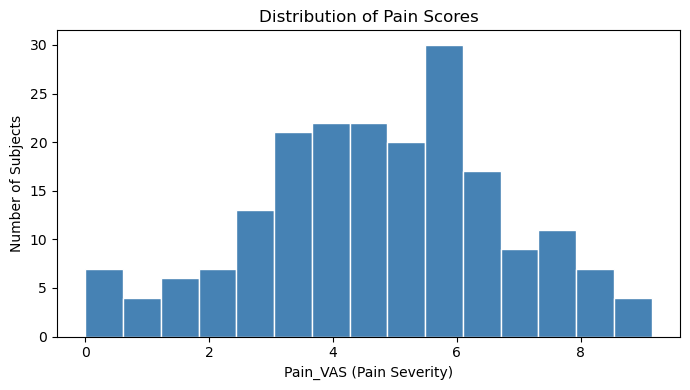

Mean: 4.7
Std: 2.0
Range: 0.0 to 9.2


In [13]:
# Always visualize your outcome variable first
plt.figure(figsize=(7, 4))
plt.hist(behavior['Pain_VAS'], bins=15, color='steelblue', edgecolor='white')
plt.xlabel('Pain_VAS (Pain Severity)')
plt.ylabel('Number of Subjects')
plt.title('Distribution of Pain Scores')
plt.tight_layout()
plt.show()

print(f'Mean: {behavior["Pain_VAS"].mean():.1f}')
print(f'Std: {behavior["Pain_VAS"].std():.1f}')
print(f'Range: {behavior["Pain_VAS"].min():.1f} to {behavior["Pain_VAS"].max():.1f}')

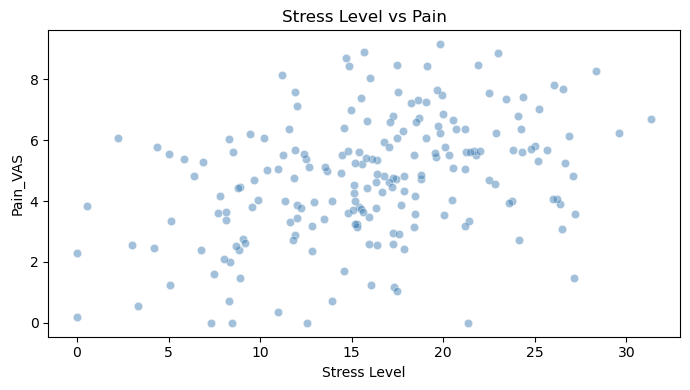

In [15]:
# Explore a relationship between two variables
plt.figure(figsize=(7, 4))
plt.scatter(behavior['Stress_Level'], behavior['Pain_VAS'], alpha=0.5,
            color='steelblue', edgecolors='white', linewidth=0.5)
plt.xlabel('Stress Level')
plt.ylabel('Pain_VAS')
plt.title('Stress Level vs Pain')
plt.tight_layout()
plt.show()

---

## Part 3: Background and Hypothesis

### Pain and Reward Circuitry

A growing body of research suggests that **reward circuitry** plays an important role in chronic pain vulnerability. The nucleus accumbens (NAc) and medial prefrontal cortex (mPFC) (key nodes of the brain's reward system) may show altered connectivity in chronic pain patients.

### Relevant Literature

> <a href="https://www.sciencedirect.com/science/article/pii/S0304395913006908">Geha et al., 2014</a>: Decreased food pleasure and disrupted satiety signals in chronic low back pain, ***Pain***

> <a href="">Yaakub et al., 2025:</a> Non-invasive ultrasonic neuromodulation of the human nucleus accumbens impacts reward sensitivity, ***Nature***

> <a href="https://pubmed.ncbi.nlm.nih.gov/25243988/">Metereau & Dreher 2015:</a> The medial orbitofrontal cortex encodes a general unsigned value signal during anticipation of both appetitive and aversive events, ***Cortex***

Read these articles (just the abstracts and maybe a few figures). 

Think about what brain regions you might expect to see functional connectivity correlate with pain symptoms. The most common way to measure pain symptoms is through the **Visual Analog Scale (VAS)**

### Your Turn: Formulate Your Hypothesis

Based on the literature above, write your hypothesis in one sentence. What brain regions do you expect to be connected to Pain_VAS? In which direction (positive or negative)?

> **H1: Connectivity between {which regions? enter here} correlates with Pain_VAS.**

This is a focused hypothesis: you are testing only the edges connecting X regions (left and right) with Y regions -- a small number of specific connections motivated by the literature.

Take a moment to think about *why* you expect this relationship. What does the literature suggest about how reward circuitry might influence pain perception?

---

## Part 4: Explore Your Target Regions

Before testing your hypothesis, examine the regions involved and visualize an example edge.

In [17]:
# What subcortical regions are available?
helpers.list_regions('Subcortical')

ROIs in Subcortical:
  [  0] HIP-rh                                             (Subcortical)
  [  1] AMY-rh                                             (Subcortical)
  [  2] pTHA-rh                                            (Subcortical)
  [  3] aTHA-rh                                            (Subcortical)
  [  4] NAc-rh                                             (Subcortical)
  [  5] GP-rh                                              (Subcortical)
  [  6] PUT-rh                                             (Subcortical)
  [  7] CAU-rh                                             (Subcortical)
  [  8] HIP-lh                                             (Subcortical)
  [  9] AMY-lh                                             (Subcortical)
  [ 10] pTHA-lh                                            (Subcortical)
  [ 11] aTHA-lh                                            (Subcortical)
  [ 12] NAc-lh                                             (Subcortical)
  [ 13] GP-lh                 

In [21]:
# What DefaultA regions are available?
helpers.list_regions('Default')

ROIs in Default Mode:
  [ 90] LH_DefaultA_IPL_1                                  (Default Mode)
  [ 91] LH_DefaultA_PFCd_1                                 (Default Mode)
  [ 92] LH_DefaultA_pCunPCC_1                              (Default Mode)
  [ 93] LH_DefaultA_pCunPCC_2                              (Default Mode)
  [ 94] LH_DefaultA_pCunPCC_3                              (Default Mode)
  [ 95] LH_DefaultA_PFCm_1                                 (Default Mode)
  [ 96] LH_DefaultA_PFCm_2                                 (Default Mode)
  [ 97] LH_DefaultA_PFCm_3                                 (Default Mode)
  [ 98] LH_DefaultB_Temp_1                                 (Default Mode)
  [ 99] LH_DefaultB_Temp_2                                 (Default Mode)
  [100] LH_DefaultB_Temp_3                                 (Default Mode)
  [101] LH_DefaultB_Temp_4                                 (Default Mode)
  [102] LH_DefaultB_IPL_1                                  (Default Mode)
  [103] LH_Defau

In [23]:
# Overview of all brain networks
helpers.list_networks()

Brain networks in the pain dataset:
Network                ROIs
----------------------------
Subcortical              16
Visual                   24
Somatomotor              34
Dorsal Attention         22
Salience                 26
Limbic                   14
Frontoparietal           37
Default Mode             43
----------------------------
Total                   216


**Tip:** Use `helpers.describe_regions('Subcortical')` to see decoded names for each region (e.g., what "NAc-rh" stands for).

In [25]:
# See decoded region names for subcortical areas
helpers.describe_regions('Subcortical')

Regions in Subcortical (decoded):
  Name                                               Hemisphere Network            Region
  -----------------------------------------------------------------------------------------------
  HIP-rh                                             Right  Subcortical        Hippocampus
  AMY-rh                                             Right  Subcortical        Amygdala
  pTHA-rh                                            Right  Subcortical        Posterior thalamus
  aTHA-rh                                            Right  Subcortical        Anterior thalamus
  NAc-rh                                             Right  Subcortical        Nucleus accumbens
  GP-rh                                              Right  Subcortical        Globus pallidus
  PUT-rh                                             Right  Subcortical        Putamen
  CAU-rh                                             Right  Subcortical        Caudate
  HIP-lh                              

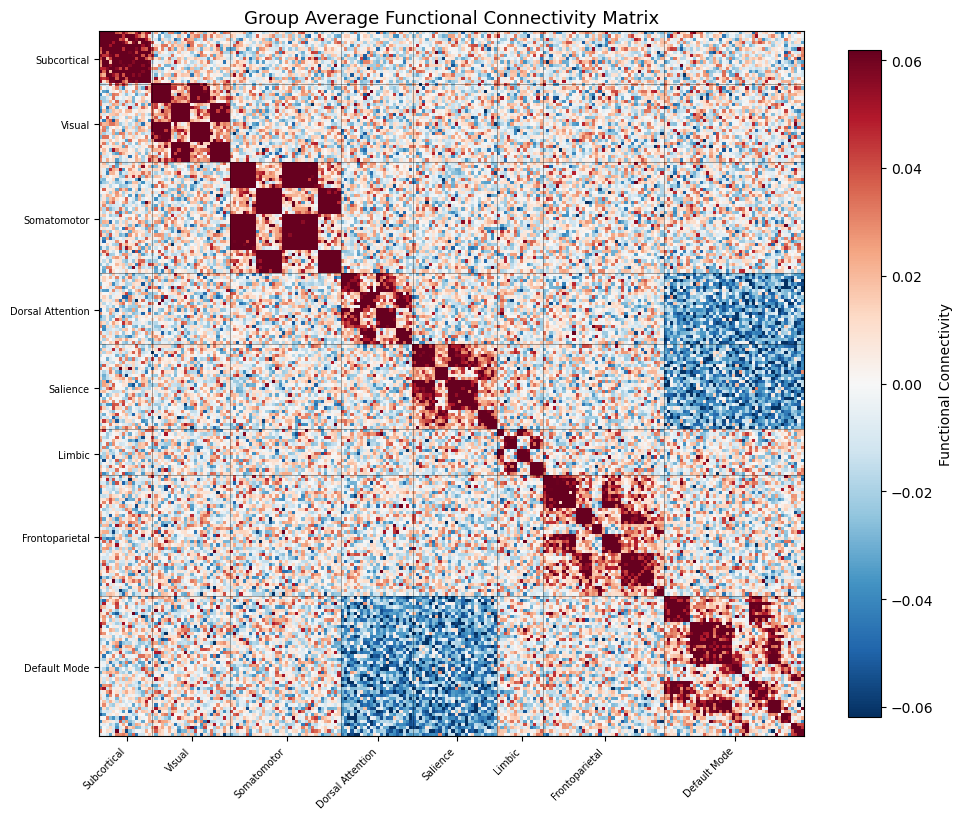

In [27]:
# Visualize the overall connectivity structure
helpers.plot_connectome()

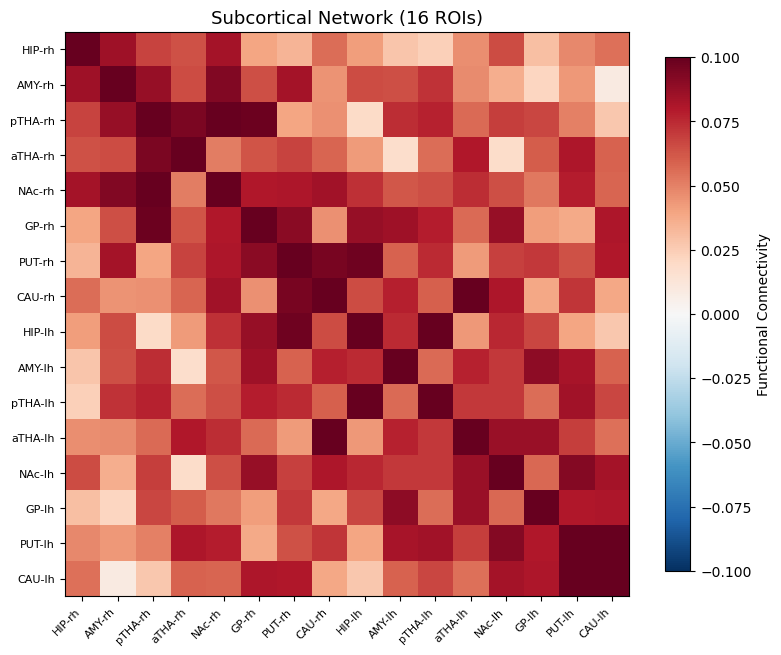

In [29]:
# Zoomed view of Subcortical network connectivity
helpers.plot_network_matrix('Subcortical')

### Visualize a Single Edge

Before diving into analysis, let's see what a brain connectivity scatter plot actually looks like. Here we'll plot the connectivity between two subcortical regions against Age -- this is just to get familiar with the visualization, not to test your hypothesis yet.

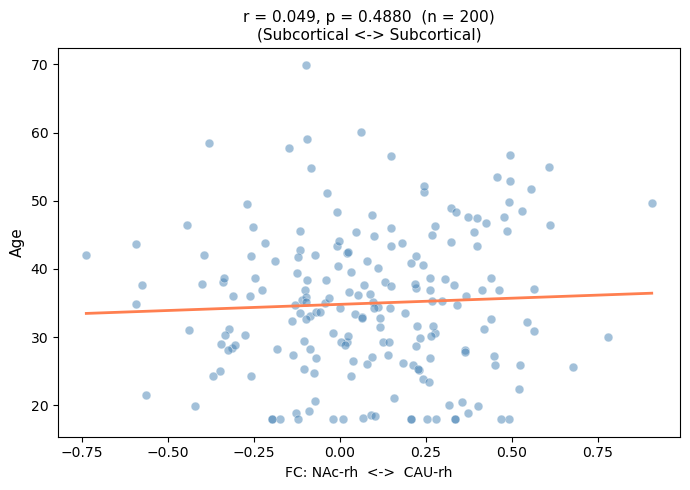

In [31]:
# Plot connectivity between two subcortical regions vs Age
# This is just to see what an FC scatter plot looks like
helpers.plot_edge('NAc-rh', 'CAU-rh', 'Age')

### Quick Reference: Functional Connectivity Concepts

**Functional connectivity (FC)** measures how correlated the activity is between two brain regions during a resting-state fMRI scan.

**Key terms:**
- **ROI (Region of Interest)**: A specific brain area. This dataset has 216 ROIs from a standard brain atlas.
- **Edge**: A connection between two ROIs. Each edge has a connectivity value per subject. With 216 ROIs, there are 23,220 unique edges.
- **Network**: ROIs are grouped into brain networks (e.g., Default Mode, Salience, Subcortical) based on their function.

**Interpreting Pearson r** (correlation strength):
- |r| < 0.10 -- negligible
- |r| around 0.10-0.20 -- small
- |r| around 0.20-0.30 -- medium
- |r| > 0.30 -- large (rare in neuroimaging)

**r-squared** (r x r) tells you the proportion of variance explained. An r of 0.20 means r-squared = 0.04 -- the brain connection explains about 4% of individual differences.

---

## Part 5: Your Analysis Toolkit

Before testing your hypothesis, let's learn the analytical tools available to you. Each tool is a standard technique that researchers use every day. Understanding these tools will help you make informed decisions when you pre-register your analysis plan in Part 6.

All of these tools work with both `plot_edge()` and the mass testing functions (`test_all_edges()`, `test_network_edges()`).

### 5a. Covariates: Controlling for Confounding Variables

A **covariate** is a variable you account for ("control for") to see whether a relationship still holds after removing its influence. When you control for a variable, the axes show "residualized" values -- what's left of each variable after statistically removing the influence of the covariate.

**Why does this matter?** Sometimes two variables look related, but the apparent relationship is actually driven by a third variable. Let's see an example with the behavioral data first, then apply the same logic to brain data.

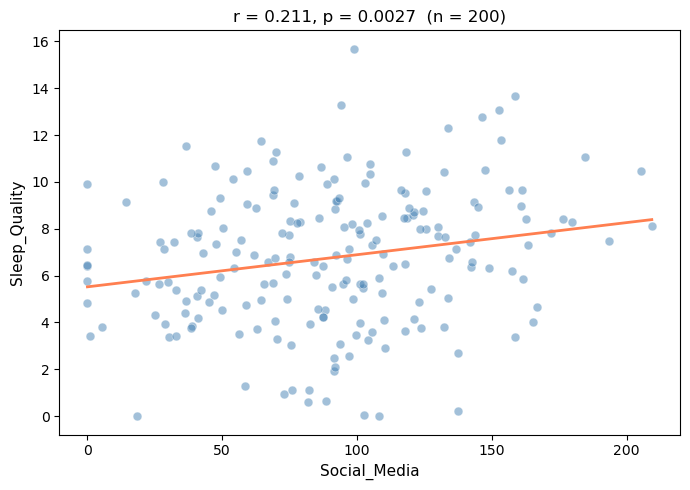

In [33]:
# Is Social_Media use related to Sleep_Quality?
helpers.plot_behavior('Social_Media', 'Sleep_Quality')

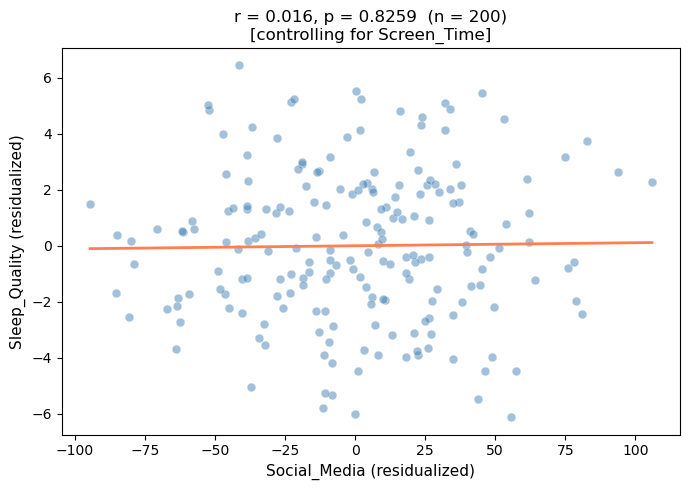

In [35]:
# People who use more screens overall may have both more social media use
# AND worse sleep. Let's control for Screen_Time and see what happens:
helpers.plot_behavior('Social_Media', 'Sleep_Quality', covariates=['Screen_Time'])

Notice how the correlation changes after controlling for Screen_Time. The apparent link between social media and sleep quality was largely driven by overall screen time.

The same principle applies to brain data. Let's see how controlling for a behavioral variable changes a brain connectivity relationship:

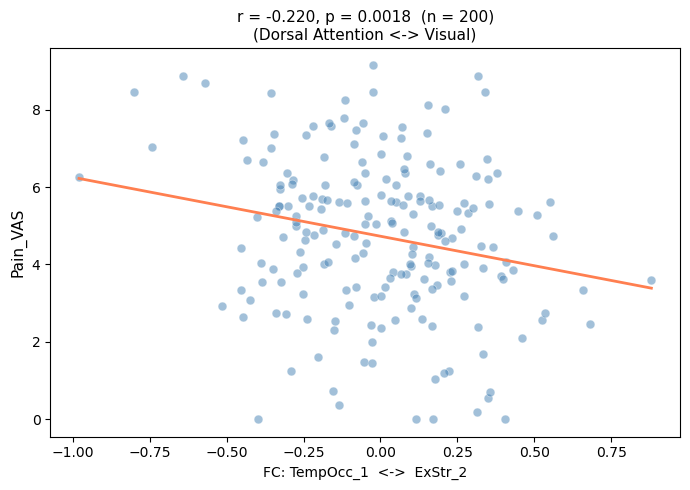

In [37]:
# Does this Dorsal Attention - Visual edge predict Pain_VAS?
helpers.plot_edge('LH_DorsAttnA_TempOcc_1', 'RH_VisCent_ExStr_2', 'Pain_VAS')

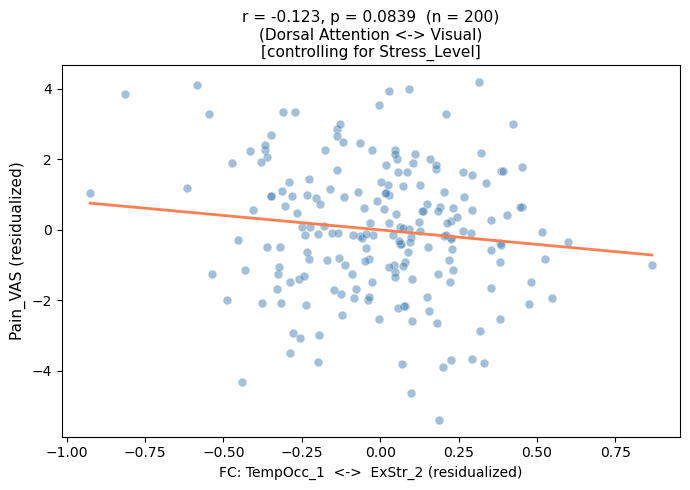

In [39]:
# Now control for Stress_Level and see what happens:
helpers.plot_edge('LH_DorsAttnA_TempOcc_1', 'RH_VisCent_ExStr_2', 'Pain_VAS',
                  covariates=['Stress_Level'])

Notice how the correlation changed after controlling for Stress_Level. Covariates can **strengthen or weaken** findings. The important thing is to choose your covariates **before** you see your results -- otherwise you might unconsciously pick covariates that make your findings look better.

### 5b. Outlier Handling

An **outlier** is a data point that is unusually far from the rest. **Z-scores** measure how many standard deviations (SD) a value is from the mean. A z-score of 2 means the value is in roughly the most extreme 5% of data; a z-score of 3 is the most extreme 0.3%.

Outliers can have a big impact on correlations. Sometimes a "significant" result is driven entirely by a few extreme values. Other times, outliers can obscure a real effect. Let's see both cases.

You can add an `exclude_outliers` argument to remove extreme values:

--- With all data ---


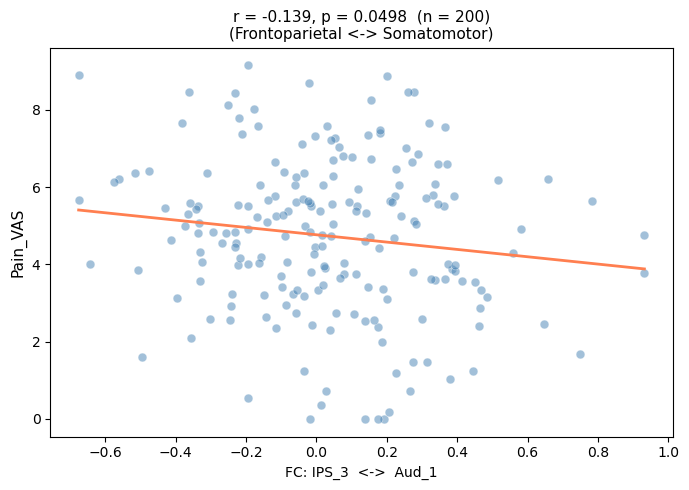

In [41]:
# EXAMPLE 1: A "significant" result that disappears when outliers are removed
print('--- With all data ---')
helpers.plot_edge('LH_ContA_IPS_3', 'RH_SomMotB_Aud_1', 'Pain_VAS')

--- After removing outliers (z > 2) ---


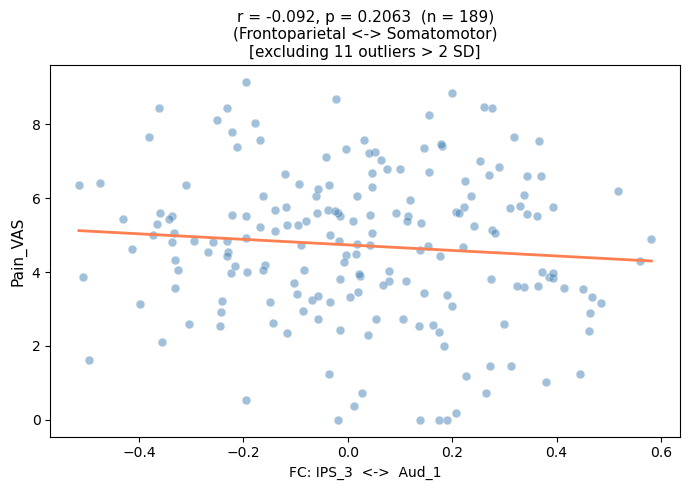

In [43]:
print('--- After removing outliers (z > 2) ---')
helpers.plot_edge('LH_ContA_IPS_3', 'RH_SomMotB_Aud_1', 'Pain_VAS',
                  exclude_outliers=2)

The correlation went from "significant" to nowhere near significant. Those few extreme data points were creating the illusion of a relationship.

Now let's see the opposite -- outliers *hiding* a real effect:

In [ ]:
# EXAMPLE 2: A real effect that only appears after removing outliers
print('--- With all data ---')
helpers.plot_edge('LH_LimbicB_OFC_2', 'RH_ContB_PFCld_1', 'Pain_VAS')

print('--- After removing outliers (z > 2) ---')
helpers.plot_edge('LH_LimbicB_OFC_2', 'RH_ContB_PFCld_1', 'Pain_VAS',
                  exclude_outliers=2)

After removing extreme values, a real relationship emerged. Outliers can work both ways -- they can create false positives or hide true effects. That is why your outlier handling strategy should be decided **in advance** as part of your pre-registration, not adjusted after seeing your results.

### 5c. Subgroup Analysis

Sometimes a relationship exists in one group but not another. For example, does anxiety relate to pain differently for men versus women?

In [ ]:
# Overall relationship: anxiety vs pain
helpers.plot_behavior('GAD7', 'Pain_VAS')

# Does the relationship differ by sex?
helpers.plot_behavior('GAD7', 'Pain_VAS', subgroup={'Sex': 0})  # women
helpers.plot_behavior('GAD7', 'Pain_VAS', subgroup={'Sex': 1})  # men

Notice how the relationship between anxiety and pain is much stronger in women than in men. Subgroup analysis can reveal effects hidden in the full sample. But there is an important trade-off: splitting your sample **reduces your sample size and statistical power**. Only analyze subgroups if you have a strong reason from the literature -- not just because it makes your results look better.

The `subgroup` argument works with brain data too:
```python
helpers.plot_edge('NAc-rh', 'RH_DefaultA_PFCm_1', 'Pain_VAS', subgroup={'Sex': 0})
```

### 5d. Multiple Comparisons

When you test many edges at once, some will appear "significant" just by chance. If you test 100 edges at p < 0.05, you would expect about 5 false positives even if there are no real effects at all.

There are two common ways to correct for this:

- **Bonferroni correction**: Divide your alpha (0.05) by the number of tests. Very conservative -- it controls the chance of *any* false positive. Simple, but can miss real effects when you have many tests.

- **FDR (False Discovery Rate) correction** (Benjamini-Hochberg): Controls the *proportion* of false positives among your significant results. Less conservative, and the standard in neuroimaging research.

Let's see this in action with an example unrelated to your hypothesis. We will test all edges within the Limbic network against Pain_VAS:

In [ ]:
# Test all within-Limbic edges vs Pain_VAS (NOT your hypothesis -- just a demo)
limbic_results = helpers.test_network_edges('Limbic', within=True)
n_limbic = len(limbic_results)

# How many are "significant" without correction?
n_uncorrected = (limbic_results['p'] < 0.05).sum()
print(f'Tested {n_limbic} within-Limbic edges')
print(f'Significant at p < 0.05 (uncorrected): {n_uncorrected}')
print(f'Expected by chance alone: {n_limbic * 0.05:.0f}')

# Now apply FDR correction
limbic_fdr = helpers.test_network_edges('Limbic', within=True, correction='fdr')
n_fdr = (limbic_fdr['p_corrected'] < 0.05).sum()
print(f'\nSignificant after FDR correction: {n_fdr}')
print(f'\nMany "findings" disappear after proper correction!')

In [ ]:
# Visualize the p-values from the Limbic network test
plt.figure(figsize=(10, 5))

colors = ['coral' if p < 0.05 else 'gray' for p in limbic_results['p']]
plt.scatter(range(n_limbic), sorted(limbic_results['p']), c=colors, s=40)
plt.axhline(0.05, color='orange', linestyle='--', linewidth=1,
            label='Uncorrected alpha = 0.05')
plt.yscale('log')
plt.xlabel('Edge (ranked by p-value)')
plt.ylabel('P-value (log scale)')
plt.title(f'{n_limbic} Within-Limbic Edges: {n_uncorrected} "significant" uncorrected, 0 after FDR')
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

print(f'Coral dots are below 0.05 -- these would be "significant" without correction.')
print(f'But none survive FDR correction. They are likely false positives.')

This is why multiple comparison correction is essential. Without it, you would report false positives as real findings. In your pre-registration below, we will use **FDR correction** as the default.

### Key Takeaway

You now have a full toolkit: **covariates**, **outlier handling**, and **subgroup analysis**. In the next section, you will formally commit to your analysis choices **before** seeing the results. This is called **pre-registration** -- it is what separates hypothesis-driven science from exploratory analysis.

---

## Part 6: Pre-Register Your Analysis

In real research, scientists often **pre-register** their analysis plan before collecting data. This means writing down exactly what you will test and how -- before you see the results. Pre-registration prevents you from unconsciously adjusting your analysis to get the answer you want.

Fill in each section below. Once you have committed to your plan, you will execute it in Part 8.

### My Pre-Registration

**Hypothesis:** Connectivity between the nucleus accumbens (NAc) and medial prefrontal cortex (DefaultA PFCm regions) correlates with Pain_VAS.

**Edges to test:** [Which specific edges will you test? e.g., "NAc <-> DefaultA_PFCm edges"]

**Number of tests:** [How many edges does this include? You will find out when you run the code in Part 8.]

**Correction method:** FDR (Benjamini-Hochberg) -- see explanation below

**Covariates:** [Which covariates will you control for, if any? Justify your choice based on the literature. Write "None" if you will not use covariates.]

**Outlier handling:** [Will you exclude outliers? If so, at what z-score threshold? (e.g., 2 or 3) Write "None" if you will not exclude outliers.]

**Subgroup analysis:** [Will you analyze any subgroups? If so, which? Write "None" if you will analyze the full sample.]

**Significance threshold:** 0.05 (after FDR correction)

---

## Part 7: Practice -- Testing a Known Effect

Before testing your hypothesis, let's practice with a well-established finding.

It is well documented in the neuroscience literature that functional connectivity within the **Default Mode Network** decreases with age. This is one of the most replicated findings in resting-state fMRI research. Let's test this in our data to build confidence with the tools before applying them to your hypothesis.

In [ ]:
# Plot a single Default Mode Network edge vs Age
# These two regions are both in the Default Mode Network:
#   - LH_DefaultA_PFCm_1 = left medial prefrontal cortex
#   - LH_DefaultA_pCunPCC_1 = left precuneus/posterior cingulate
helpers.plot_edge('LH_DefaultA_PFCm_1', 'LH_DefaultA_pCunPCC_1', 'Age')

In [ ]:
# Test all within-Default Mode edges vs Age with FDR correction
dmn_age = helpers.test_network_edges('Default Mode', behavior_col='Age',
                                      correction='fdr', within=True)

n_sig = (dmn_age['p_corrected'] < 0.05).sum()
print(f"\nEdges with significant age-related decline (FDR corrected): {n_sig}")

# Show the top findings
print("\nTop 10 within-Default Mode edges correlated with Age:")
print(dmn_age.head(10)[['ROI_A', 'ROI_B', 'r', 'p', 'p_corrected']].to_string())

You should see mostly **negative correlations** -- as age increases, Default Mode Network connectivity decreases. This is one of the most replicated findings in neuroscience.

If you see significant results after FDR correction, that confirms the tools are working correctly and the data contains real brain-behavior relationships.

Now you are ready to test your own hypothesis.

---

## Part 8: Test Your Hypothesis

Now execute your pre-registered analysis plan. The code below tests your hypothesis edges -- NAc regions connected to DefaultA PFCm regions.

In [ ]:
# Step 1: Test edges involving the Subcortical network
# We focus on Subcortical because our hypothesis is about NAc (nucleus accumbens)
all_results = helpers.test_network_edges('Subcortical')

In [ ]:
# Step 2: Filter to your specific hypothesis edges
# Keep only rows where one region is NAc and the other is DefaultA PFCm
hyp_mask = (
    (all_results['ROI_A'].str.contains('NAc') & all_results['ROI_B'].str.contains('DefaultA_PFCm')) |
    (all_results['ROI_B'].str.contains('NAc') & all_results['ROI_A'].str.contains('DefaultA_PFCm'))
)
hyp_results = all_results[hyp_mask].reset_index(drop=True)

n_hyp_tests = len(hyp_results)
print(f"NAc <-> DefaultA PFCm edges to test: {n_hyp_tests}")
print(f"\nAll results (sorted by p-value):")
hyp_results

### Apply Your Pre-Registered Choices

Modify the code below based on what you wrote in your pre-registration (Part 6). If you chose not to use covariates, outliers, or subgroups, leave them set to `None`.

In [ ]:
# Step 3: Apply your pre-registered analysis choices
# Edit these variables based on what you wrote in your pre-registration:

covariates = None              # e.g., ['Age', 'Sex'] or None for no covariates
outlier_threshold = None       # e.g., 2 or 3, or None for no outlier removal
subgroup = None                # e.g., {'Sex': 0} or None for full sample

# Re-test with your pre-registered choices (only if you specified any)
if covariates is not None or outlier_threshold is not None or subgroup is not None:
    all_results = helpers.test_network_edges('Subcortical',
                                              covariates=covariates,
                                              exclude_outliers=outlier_threshold,
                                              subgroup=subgroup)

    # Re-filter to hypothesis edges (recompute the mask for the new results)
    hyp_mask = (
        (all_results['ROI_A'].str.contains('NAc') & all_results['ROI_B'].str.contains('DefaultA_PFCm')) |
        (all_results['ROI_B'].str.contains('NAc') & all_results['ROI_A'].str.contains('DefaultA_PFCm'))
    )
    hyp_results = all_results[hyp_mask].reset_index(drop=True)
    n_hyp_tests = len(hyp_results)
    print(f"\nRe-filtered to {n_hyp_tests} hypothesis edges with your pre-registered choices.")
    print(hyp_results[['ROI_A', 'ROI_B', 'r', 'p']].to_string())
else:
    print("No covariates, outlier removal, or subgroup specified.")
    print("Using the results from Step 2 above.")

### Apply Multiple Comparison Correction

Because you are testing multiple edges, you need to correct for multiple comparisons. There are two common approaches:

- **Bonferroni correction**: Divides your alpha (0.05) by the number of tests. Very conservative -- it controls the probability of even one false positive. Simple but can miss real effects.

- **FDR (False Discovery Rate) correction**: Controls the *proportion* of false positives among your significant results. Less conservative than Bonferroni, and widely used in neuroimaging research.

We will use **FDR correction** (Benjamini-Hochberg method), which is the standard approach in neuroimaging and is what the exploratory group used as well.

In [ ]:
from statsmodels.stats.multitest import multipletests

alpha = 0.05

# Apply FDR (Benjamini-Hochberg) correction
reject, p_corrected, _, _ = multipletests(hyp_results['p'], alpha=alpha, method='fdr_bh')
hyp_results['p_corrected'] = p_corrected
hyp_results['significant_fdr'] = reject

# For reference, also compute Bonferroni threshold
bonferroni_threshold = alpha / n_hyp_tests

n_significant = hyp_results['significant_fdr'].sum()

print('=' * 60)
print('MULTIPLE COMPARISON CORRECTION')
print('=' * 60)
print(f'Number of tests: {n_hyp_tests}')
print(f'Method: FDR (Benjamini-Hochberg)')
print(f'For reference -- Bonferroni threshold would be: {bonferroni_threshold:.6f}')
print(f'\nSignificant after FDR correction: {n_significant}')

if n_significant > 0:
    print(f'\nSignificant edges:')
    sig = hyp_results[hyp_results['significant_fdr']]
    for _, row in sig.iterrows():
        print(f"  {row['ROI_A']} <-> {row['ROI_B']}: r={row['r']:.3f}, p={row['p']:.2e}, p_fdr={row['p_corrected']:.2e}")
else:
    print('\nNo edges survived FDR correction.')
    print('Most promising edge:')
    top = hyp_results.iloc[0]
    print(f"  {top['ROI_A']} <-> {top['ROI_B']}: r={top['r']:.3f}, p={top['p']:.2e}")

In [ ]:
# Visualize the top hypothesis-driven findings
def _short_name(roi):
    """Extract readable short name from ROI label."""
    if '-' in roi:  # Subcortical (e.g., NAc-rh)
        return roi
    parts = roi.split('_')
    if len(parts) >= 4:
        return '_'.join(parts[1:-1])  # e.g. DefaultA_PFCm
    return roi

if n_significant > 0:
    sig_edges = hyp_results[hyp_results['significant_fdr']]
    n_plots = min(len(sig_edges), 3)
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 4))
    if n_plots == 1:
        axes = [axes]

    for idx, (_, row) in enumerate(sig_edges.head(n_plots).iterrows()):
        edge_vals = helpers.get_edge(row['ROI_A'], row['ROI_B'])
        outcome = behavior['Pain_VAS'].values
        r_val, p_val = pearsonr(edge_vals, outcome)

        axes[idx].scatter(edge_vals, outcome, alpha=0.5, color='steelblue')
        z = np.polyfit(edge_vals, outcome, 1)
        x_line = np.linspace(edge_vals.min(), edge_vals.max(), 100)
        axes[idx].plot(x_line, np.polyval(z, x_line), color='coral', linewidth=2)
        axes[idx].set_xlabel('Functional Connectivity')
        axes[idx].set_ylabel('Pain_VAS')

        short_a = _short_name(row['ROI_A'])
        short_b = _short_name(row['ROI_B'])
        axes[idx].set_title(f'{short_a} <-> {short_b}\nr = {r_val:.3f}, p = {p_val:.2e}')

    plt.tight_layout()
    plt.show()
else:
    # Plot most promising even if not significant
    top = hyp_results.iloc[0]
    helpers.plot_edge(top['ROI_A'], top['ROI_B'], 'Pain_VAS')

### Visualize Results on the Brain

Let's see where your significant edges are located in 3D brain space:

In [ ]:
# Plot significant edges on a glass brain (using FDR-corrected p-values)
helpers.plot_glass_brain(hyp_results, p_threshold=0.05, corrected=True)

In [ ]:
# P-value visualization for all hypothesis tests
plt.figure(figsize=(10, 5))

colors = ['mediumseagreen' if sig else 'gray' for sig in hyp_results['significant_fdr']]
plt.scatter(range(len(hyp_results)), hyp_results['p'], c=colors, s=60)
plt.axhline(bonferroni_threshold, color='coral', linestyle='--', linewidth=1,
            label=f'Bonferroni threshold (p={bonferroni_threshold:.2e})')
plt.axhline(0.05, color='orange', linestyle='--', linewidth=1,
            label='Uncorrected alpha = 0.05')
plt.yscale('log')
plt.xlabel('Edge (ranked by p-value)')
plt.ylabel('P-value (log scale)')
plt.title(f'P-values for {n_hyp_tests} NAc-PFCm Tests')
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

print(f'Green dots = significant after FDR correction')
print(f'Note: FDR correction uses a step-up procedure, not a single threshold line.')
print(f'The Bonferroni line is shown for reference only.')

---

## Part 9: Prepare Your Presentation

For next class, prepare a brief presentation (5-7 minutes) covering:

1. **Your hypothesis** -- What did you predict and why?
2. **Your pre-registered methods** -- Which edges did you test? What correction, covariates, and outlier threshold did you use?
3. **Your results** -- Report ALL tests (not just significant ones). Show visualizations.
4. **Why you believe your findings** -- What makes you confident? Do the brain regions make sense?
5. **How would you convince a skeptic?** -- What evidence would you point to?

**Important**: Be honest about null results! Rigorous science means reporting what you found, not just what you hoped to find.

In [ ]:
# Save your key figures for your presentation
# Re-plot your strongest finding and save it
if n_significant > 0:
    top = hyp_results[hyp_results['significant_fdr']].iloc[0]
    helpers.plot_edge(top['ROI_A'], top['ROI_B'], 'Pain_VAS',
                      covariates=covariates,
                      exclude_outliers=outlier_threshold,
                      subgroup=subgroup)
    plt.savefig('my_finding.png', dpi=150, bbox_inches='tight')
    print("Figure saved as 'my_finding.png'")
    print("Download this file for your presentation.")
else:
    top = hyp_results.iloc[0]
    helpers.plot_edge(top['ROI_A'], top['ROI_B'], 'Pain_VAS',
                      covariates=covariates,
                      exclude_outliers=outlier_threshold,
                      subgroup=subgroup)
    plt.savefig('my_finding.png', dpi=150, bbox_inches='tight')
    print("Figure saved as 'my_finding.png'")
    print("Even null results are worth presenting!")

### Submit Your Notebook

When you are finished with Day 1, download this notebook and email it to **caleb_mahlen@urmc.rochester.edu**.

To download from Colab: **File → Download → Download .ipynb**

Your pre-registration, code, and any output you have generated will all be saved in the file.

---
---

# DAY 2 STARTS HERE

---

---

## Part 10: Reconnect and Reflect

If your Colab runtime disconnected since Day 1, run the cell below to reload everything. If your runtime is still active, you can skip it.

In [ ]:
# Day 2 Setup: Re-run if your runtime disconnected
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'nilearn', '-q'])

import os, urllib.request
base_url = 'https://raw.githubusercontent.com/cmahlen/python-stats-demo/main/'
files_needed = [
    'lab_helpers.py', 'atlas_labels.txt', 'data/roi_mni_coords.npy',
    'data/pain_discovery.npz', 'data/pain_validation.npz',
]
os.makedirs('data', exist_ok=True)
for f in files_needed:
    if not os.path.exists(f):
        urllib.request.urlretrieve(base_url + f, f)

import lab_helpers as helpers
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

helpers.load_dataset('pain', 'discovery')
behavior = helpers.get_behavior()

# Re-run your hypothesis test
all_results = helpers.test_network_edges('Subcortical')
hyp_mask = (
    (all_results['ROI_A'].str.contains('NAc') & all_results['ROI_B'].str.contains('DefaultA_PFCm')) |
    (all_results['ROI_B'].str.contains('NAc') & all_results['ROI_A'].str.contains('DefaultA_PFCm'))
)
hyp_results = all_results[hyp_mask].reset_index(drop=True)
n_hyp_tests = len(hyp_results)

# Re-apply your pre-registered choices
covariates = None              # <-- Match what you used on Day 1
outlier_threshold = None       # <-- Match what you used on Day 1
subgroup = None                # <-- Match what you used on Day 1

if covariates is not None or outlier_threshold is not None or subgroup is not None:
    all_results = helpers.test_network_edges('Subcortical',
                                              covariates=covariates,
                                              exclude_outliers=outlier_threshold,
                                              subgroup=subgroup)
    hyp_mask = (
        (all_results['ROI_A'].str.contains('NAc') & all_results['ROI_B'].str.contains('DefaultA_PFCm')) |
        (all_results['ROI_B'].str.contains('NAc') & all_results['ROI_A'].str.contains('DefaultA_PFCm'))
    )
    hyp_results = all_results[hyp_mask].reset_index(drop=True)
    n_hyp_tests = len(hyp_results)

alpha = 0.05
reject, p_corrected, _, _ = multipletests(hyp_results['p'], alpha=alpha, method='fdr_bh')
hyp_results['p_corrected'] = p_corrected
hyp_results['significant_fdr'] = reject
bonferroni_threshold = alpha / n_hyp_tests
n_significant = hyp_results['significant_fdr'].sum()

def _short_name(roi):
    """Extract readable short name from ROI label."""
    if '-' in roi:
        return roi
    parts = roi.split('_')
    if len(parts) >= 4:
        return '_'.join(parts[1:-1])
    return roi

print(f"\nReloaded! {n_significant} significant edges (FDR corrected)")

### Reflection Questions

Before we test your findings in the validation data, think about these questions:

1. **How confident are you that your findings will replicate?**
   - What would make you more or less confident?

2. **What could go wrong?**
   - Even with Bonferroni correction, could your results still be false positives?

3. **How is your approach different from the exploratory group's?**
   - How many tests did you run compared to them?
   - Did you choose your analysis plan before or after seeing the results?

4. **Effect sizes**
   - How strong were the correlations you found?
   - Are these practically meaningful for understanding pain?

---

## Part 11: Validation

### Test your findings in the independent validation set

True effects should replicate in new data. You will now re-run your **exact pre-registered analysis** on the validation dataset.

In [ ]:
# Load the validation dataset
helpers.load_dataset('pain', 'validation')

The cell below tests each of your hypothesis edges in the validation dataset and compares the results to your discovery findings. An edge "replicates" if it is significant in the same direction in both datasets. You do not need to understand every line of code -- just run the cell and read the output.

In [ ]:
import pandas as pd

# Test ALL hypothesis edges in validation using the SAME analysis choices
val_behavior = helpers.get_behavior()
val_outcome = val_behavior['Pain_VAS'].values

validation_results = []
for _, row in hyp_results.iterrows():
    edge_vals = helpers.get_edge(row['ROI_A'], row['ROI_B'])
    r_val, p_val = pearsonr(edge_vals, val_outcome)

    sig_disc = row['significant_fdr']
    # Check both significance AND direction (sign of r must match)
    same_direction = (r_val * row['r']) > 0
    if sig_disc:
        if p_val < 0.05 and same_direction:
            replicated = 'YES'
        elif p_val < 0.05 and not same_direction:
            replicated = 'FLIPPED'
        else:
            replicated = 'NO'
    else:
        replicated = 'N/A'

    validation_results.append({
        'ROI_A': row['ROI_A'],
        'ROI_B': row['ROI_B'],
        'Disc_r': row['r'],
        'Disc_p': row['p'],
        'Sig_Disc': sig_disc,
        'Val_r': r_val,
        'Val_p': p_val,
        'Replicated': replicated,
    })

val_df = pd.DataFrame(validation_results)

print('=' * 80)
print('VALIDATION RESULTS: NAc-PFCm Edges')
print('=' * 80)
print(f'Validation uses uncorrected p < 0.05 + same direction as replication criterion\n')

display_df = val_df[['ROI_A', 'ROI_B', 'Disc_r', 'Disc_p', 'Sig_Disc', 'Val_r', 'Val_p', 'Replicated']]
display_df.index = range(1, len(display_df) + 1)
print(display_df.to_string())

if n_significant > 0:
    n_rep = (val_df['Replicated'] == 'YES').sum()
    print(f"\n{'=' * 80}")
    print(f'REPLICATION: {n_rep}/{n_significant} significant findings replicated')
    print(f"{'=' * 80}")

n_flipped = (val_df['Replicated'] == 'FLIPPED').sum()
if n_flipped > 0:
    print(f'WARNING: {n_flipped} finding(s) were significant but in the OPPOSITE direction!')
    print('A flipped direction means the effect is not replicating -- it is noise.')

The cell below creates side-by-side scatter plots comparing your discovery and validation results. The left plot shows the discovery set; the right plot shows the validation set. If the finding replicated, both plots should show a similar pattern.

In [ ]:
# Side-by-side visualization for significant finding(s)
if n_significant > 0:
    sig_rows = val_df[val_df['Sig_Disc'] == True]

    for _, row in sig_rows.iterrows():
        fig, axes = plt.subplots(1, 2, figsize=(13, 5))

        # Discovery
        helpers.load_dataset('pain', 'discovery')
        disc_edge = helpers.get_edge(row['ROI_A'], row['ROI_B'])
        disc_out = helpers.get_behavior()['Pain_VAS'].values
        r_d, p_d = pearsonr(disc_edge, disc_out)

        axes[0].scatter(disc_edge, disc_out, alpha=0.5, color='steelblue')
        z = np.polyfit(disc_edge, disc_out, 1)
        x_line = np.linspace(disc_edge.min(), disc_edge.max(), 100)
        axes[0].plot(x_line, np.polyval(z, x_line), color='coral', linewidth=2)
        axes[0].set_xlabel('Functional Connectivity')
        axes[0].set_ylabel('Pain_VAS')
        axes[0].set_title(f'Discovery Set\nr = {r_d:.3f}, p = {p_d:.2e}')

        # Validation
        helpers.load_dataset('pain', 'validation')
        val_edge = helpers.get_edge(row['ROI_A'], row['ROI_B'])
        val_out = helpers.get_behavior()['Pain_VAS'].values
        r_v, p_v = pearsonr(val_edge, val_out)

        axes[1].scatter(val_edge, val_out, alpha=0.5, color='mediumseagreen')
        z = np.polyfit(val_edge, val_out, 1)
        x_line = np.linspace(val_edge.min(), val_edge.max(), 100)
        axes[1].plot(x_line, np.polyval(z, x_line), color='coral', linewidth=2)
        axes[1].set_xlabel('Functional Connectivity')
        axes[1].set_ylabel('Pain_VAS')
        axes[1].set_title(f'Validation Set\nr = {r_v:.3f}, p = {p_v:.2e}')

        short_a = _short_name(row['ROI_A'])
        short_b = _short_name(row['ROI_B'])
        fig.suptitle(f'{short_a} <-> {short_b}: Discovery vs Validation', fontsize=13)
        plt.tight_layout()
        plt.show()

        if row['Replicated'] == 'YES':
            print(f'REPLICATED in validation set!')
        else:
            print(f'Did not replicate in validation set.')
        print()
else:
    print('No significant findings to visualize.')

### Your Turn: Test a Non-Significant Edge in Validation

Pick one edge from your hypothesis set that was NOT significant in discovery. Does it look any different in validation? This helps build intuition about what "noise" looks like.

<details>
<summary>Hint: Example code</summary>

```python
# Pick the last (least significant) edge from your hypothesis results
nonsig = hyp_results.iloc[-1]
helpers.plot_edge(nonsig['ROI_A'], nonsig['ROI_B'], 'Pain_VAS')
```
</details>

In [ ]:
# Your Turn: test a non-significant edge here
